# 对Lena进行二值化
# 01：OpenCV

## 检查Lena的图片 
我们首先导入OpenCV-Python库用作图像处理，matplotlib库用作绘图。

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

我们可以通过`imread`方法读取jpg格式的图片，原图是一张400x400大小的三通道的图片。

In [2]:
img = cv2.imread("./lena.jpg")
print("原始图像尺寸：{}".format(img.shape))

原始图像尺寸：(400, 400, 3)


通过`imshow`方法进行图片显示。

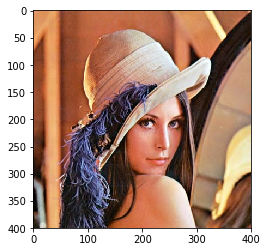

In [3]:
plt.imshow(img[:,:,::-1])

In [4]:
print(img.shape)

(400, 400, 3)


### RGB图转灰度图
将RGB图像转为灰度图，我们可以直观的看到数据维度的变化。

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("灰度图尺寸：{}".format(gray.shape))

灰度图尺寸：(400, 400)


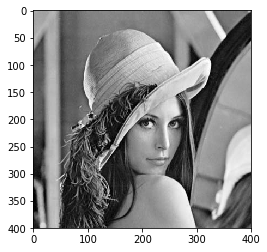

In [6]:
plt.imshow(gray,cmap='gray')

### 二值化处理

In [7]:
import time

start_time = time.time()

ret, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.0020515918731689453s


绘制上述三幅图像。

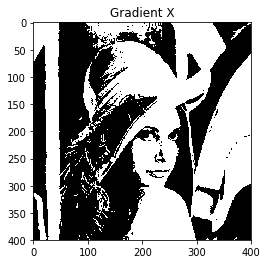

In [8]:
fig_sobel3 = plt.figure()
fig_sobel3.set_figheight(4)
fig_sobel3.set_figwidth(15)
# gradient x
fig_1 = fig_sobel3.add_subplot(131)
fig_1.title.set_text('Gradient X')
plt.imshow(binary,cmap='gray')

# 02:  Hardware Binarization
## 方式1：直接调用
### 载入Overlay

将硬件设计部署到板卡上，根据图片尺寸分配内存，并将图像复制到对应位置。

In [9]:
from pynq import Overlay, allocate

overlay = Overlay("./design_1.bit")

Binarization = overlay.rgb2yuv_0

In [10]:
# allocate memory
import sys
rows, cols= gray.shape
print(gray.shape)
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')
# input
gray_new = np.uint8(gray)
np.copyto(input_buffer, gray_new.flatten())

(400, 400)


### 写入参数
在IP上写入值时，我们可以像Lab1一样根据HLS给出的IP Driver Source Code直接在对应位置写入：

In [11]:
Binarization.write(0x10, rows)
Binarization.write(0x18, cols)
Binarization.write(0x20, 128)

In [12]:
Binarization.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  rows = Register(rows=400),
  cols = Register(cols=400),
  cons = Register(cons=128)
}

我们也可以直接在Register Map中与其交互，而不需要去手动输入对应的地址：

In [13]:
Binarization.register_map.rows = rows
Binarization.register_map.cols = cols

### 启动IP

将IP中的DMA对象提取出来。

In [14]:
dma = overlay.axi_dma_0

Binarization IP 使用了AXI Stream的接口格式。
- 我们需要调用DMA读取输入缓冲，并将数据发送到AXI Stream Master
- 之后，DMA应从AXI Stream Slave中将结果写回到输出缓冲中
- `wait`语句确保了DMA的处理操作已经完成

In [15]:
import time

Binarization.register_map.CTRL.AP_START = 1

start_time = time.time()

dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
#dma.sendchannel.wait() # wait for send channel
dma.recvchannel.wait() # wait for recv channel

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.003180980682373047s


将结果进行可视化。

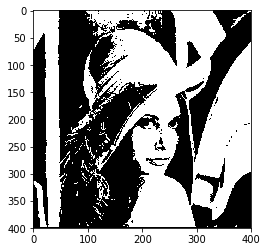

In [16]:
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')